<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex05/leonardo_lellis/Aula_5_Exerc%C3%ADcio_Leonardo_de_Lellis_Rossi_RA261900.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = "Leonardo de Lellis Rossi - RA 261900"
print(f'Meu nome é {nome}')

Meu nome é Leonardo de Lellis Rossi - RA 261900


Este exercicío consiste em treinar no MNIST um modelo de umas camadas, sendo a primeira uma camada convolucional e a segunda uma camada linear de classificação.

Não podemos usar as funções torch.nn.Conv{1,2,3}d

Neptune: https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-27/charts

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

import random
import math
from tqdm import tqdm

In [3]:
 !pip install -U neptune-client
 import neptune.new as neptune

In [4]:
run = neptune.init(name= 'Ex. Aula 5', tags=['Aula 5', 'MNIST', 'Conv', 'CrossEntropy', 'SGD'],
    project="leolellisr/dl-ia025",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==",
)

debug = False

https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-28


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Fixando as seeds

In [5]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Define pesos iniciais

In [6]:
in_channels = 1
out_channels = 2
kernel_size = 5
stride = 3

# Input image size
height_in = 28  
width_in = 28

# Image size after the first convolutional layer.
height_out = (height_in - kernel_size) // stride + 1
width_out = (width_in - kernel_size) // stride + 1

initial_conv_weight = torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01)
initial_conv_bias = torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01)

initial_classification_weight = torch.FloatTensor(10, out_channels * height_out * width_out).uniform_(-0.01, 0.01)
initial_classification_bias = torch.FloatTensor(10,).uniform_(-0.01, 0.01)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [7]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [8]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [9]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

## Define os pesos iniciais

In [10]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [11]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Camada Convolucional

https://cs231n.github.io/convolutional-networks/

In [12]:
class MyConv2d(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size  # The same for height and width.
        self.stride = stride  # The same for height and width.
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_channels, in_channels, kernel_size, kernel_size).uniform_(-0.01, 0.01))
        self.bias = torch.nn.Parameter(torch.FloatTensor(out_channels,).uniform_(-0.01, 0.01))

    def forward(self, x):
        assert x.dim() == 4, f'x must have 4 dimensions: {x.shape}'
        # Escreva seu código aqui.
        if debug: print(f"input shape = {x.shape}")
        
        width = (x.shape[2]-self.kernel_size)//self.stride+1
        height = (x.shape[3]-self.kernel_size)//self.stride+1

        out = torch.zeros(x.shape[0], self.out_channels, width, height)
        if debug: print(f"out shape = {out.shape}")
        
        # Convolution
        for k in range(self.out_channels):
          for i in range(self.kernel_size):
            for j in range(self.kernel_size):
              conv_window = x[:, :, i:(x.shape[2]-self.kernel_size+1+i):self.stride, j:(x.shape[3]-self.kernel_size+1+j):self.stride]
              if self.in_channels>1: out[:,k:k+1,:,:]+=(conv_window*self.weight[k,0:self.in_channels,i,j].view(1,self.in_channels,1,1)).sum(dim=1)
              else: out[:,k:k+1,:,:]+=(conv_window*self.weight[k,0:self.in_channels,i,j].view(1,self.in_channels,1,1))
        
          out[:,k:k+1,:,:]+=self.bias[k]
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo simples

In [13]:
in_channels_dummy = 1
out_channels_dummy = 1
kernel_size_dummy = 2
stride_dummy = 1

conv_layer = MyConv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels_dummy, out_channels=out_channels_dummy, kernel_size=kernel_size_dummy, stride=stride_dummy, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
initial_weights_dummy = torch.arange(in_channels_dummy * out_channels_dummy * kernel_size_dummy * kernel_size_dummy).float()
initial_weights_dummy = initial_weights_dummy.reshape(out_channels_dummy, in_channels_dummy, kernel_size_dummy, kernel_size_dummy)
initial_bias_dummy = torch.arange(out_channels_dummy,).float()

conv_layer.weight.data = initial_weights_dummy
conv_layer.bias.data = initial_bias_dummy
pytorch_conv_layer.load_state_dict(dict(weight=initial_weights_dummy, bias=initial_bias_dummy))

x = torch.arange(30).float().reshape(1, 1, 5, 6)

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [14]:
x = torch.rand(2, in_channels, height_in, width_in)

conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
pytorch_conv_layer = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0)

# Usa os mesmos pesos para minha implementação e a do pytorch
conv_layer.weight.data = initial_conv_weight
conv_layer.bias.data = initial_conv_bias
pytorch_conv_layer.load_state_dict(dict(weight=initial_conv_weight, bias=initial_conv_bias))

out = conv_layer(x)
target_out = pytorch_conv_layer(x)

assert torch.allclose(out, target_out, atol=1e-6)

## Modelo

In [15]:
class Net(torch.nn.Module):
    def __init__(self, height_in: int, width_in: int, in_channels: int, out_channels: int, kernel_size: int, stride: int):
        super(Net, self).__init__()
        self.conv_layer = MyConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
   
        height_out = (height_in - kernel_size) // stride + 1
        width_out = (width_in - kernel_size) // stride + 1
        self.classification_layer = torch.nn.Linear(out_channels * height_out * width_out, 10)

    def forward(self, x):
        hidden = self.conv_layer(x)
        hidden = torch.nn.functional.relu(hidden)
        hidden = hidden.reshape(x.shape[0], -1)
        logits = self.classification_layer(hidden)
        return logits

## Treinamento

### Definição dos hiperparâmetros

In [16]:
params = {'n_epochs': 50,
          'lr': 0.1,
          'Loss': 'CrossEntropyLoss',
          'optimizer': 'SGD',
         }

# Neptune
run['parameters'] = params

### Laço de treinamento

In [17]:
model = Net(height_in=height_in, width_in=width_in, in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

# Usa pesos iniciais pré-difinidos
model.classification_layer.load_state_dict(dict(weight=initial_classification_weight, bias=initial_classification_bias))
model.conv_layer.weight.data = initial_conv_weight
model.conv_layer.bias.data = initial_conv_bias

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), params["lr"])

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in tqdm(range(params["n_epochs"])):
    for x_train, y_train in loader_train:
        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())
        run['train/loss'].log(loss.item()) # Envia loss para o Neptune.
    loss_epoch_end.append(loss.item())
    run['train/loss_end'].log(loss.item()) # Envia loss para o Neptune.
    print(f'Epoch: {i:d}/{params["n_epochs"] - 1:d} Loss: {loss.item()}')


  2%|▏         | 1/50 [00:00<00:26,  1.85it/s]

Epoch: 0/49 Loss: 2.303267478942871


  4%|▍         | 2/50 [00:01<00:23,  2.02it/s]

Epoch: 1/49 Loss: 2.227701187133789


  6%|▌         | 3/50 [00:01<00:19,  2.35it/s]

Epoch: 2/49 Loss: 1.0923893451690674


  8%|▊         | 4/50 [00:01<00:17,  2.63it/s]

Epoch: 3/49 Loss: 0.5867354869842529


 10%|█         | 5/50 [00:02<00:16,  2.70it/s]

Epoch: 4/49 Loss: 0.5144088864326477


 12%|█▏        | 6/50 [00:02<00:17,  2.48it/s]

Epoch: 5/49 Loss: 0.4502663314342499


 14%|█▍        | 7/50 [00:02<00:15,  2.71it/s]

Epoch: 6/49 Loss: 0.4075140655040741


 16%|█▌        | 8/50 [00:03<00:14,  2.87it/s]

Epoch: 7/49 Loss: 0.37713873386383057


 18%|█▊        | 9/50 [00:03<00:13,  2.95it/s]

Epoch: 8/49 Loss: 0.3534485995769501


 20%|██        | 10/50 [00:03<00:12,  3.09it/s]

Epoch: 9/49 Loss: 0.3341451585292816


 22%|██▏       | 11/50 [00:04<00:15,  2.56it/s]

Epoch: 10/49 Loss: 0.3181140422821045


 24%|██▍       | 12/50 [00:04<00:17,  2.20it/s]

Epoch: 11/49 Loss: 0.30457887053489685


 26%|██▌       | 13/50 [00:05<00:19,  1.85it/s]

Epoch: 12/49 Loss: 0.2928348779678345


 28%|██▊       | 14/50 [00:06<00:21,  1.69it/s]

Epoch: 13/49 Loss: 0.2827608287334442


 30%|███       | 15/50 [00:06<00:21,  1.64it/s]

Epoch: 14/49 Loss: 0.2738332748413086


 32%|███▏      | 16/50 [00:07<00:21,  1.57it/s]

Epoch: 15/49 Loss: 0.26577427983283997


 34%|███▍      | 17/50 [00:08<00:24,  1.37it/s]

Epoch: 16/49 Loss: 0.2583288252353668


 36%|███▌      | 18/50 [00:09<00:22,  1.41it/s]

Epoch: 17/49 Loss: 0.25117501616477966


 38%|███▊      | 19/50 [00:09<00:21,  1.43it/s]

Epoch: 18/49 Loss: 0.24439716339111328


 40%|████      | 20/50 [00:10<00:20,  1.44it/s]

Epoch: 19/49 Loss: 0.2378995716571808


 42%|████▏     | 21/50 [00:11<00:20,  1.39it/s]

Epoch: 20/49 Loss: 0.23167717456817627


 44%|████▍     | 22/50 [00:12<00:19,  1.44it/s]

Epoch: 21/49 Loss: 0.22562651336193085


 46%|████▌     | 23/50 [00:12<00:20,  1.31it/s]

Epoch: 22/49 Loss: 0.21984528005123138


 48%|████▊     | 24/50 [00:13<00:18,  1.42it/s]

Epoch: 23/49 Loss: 0.21429124474525452


 50%|█████     | 25/50 [00:14<00:16,  1.52it/s]

Epoch: 24/49 Loss: 0.20894214510917664


 52%|█████▏    | 26/50 [00:14<00:16,  1.49it/s]

Epoch: 25/49 Loss: 0.2038729339838028


 54%|█████▍    | 27/50 [00:15<00:15,  1.46it/s]

Epoch: 26/49 Loss: 0.19903428852558136


 56%|█████▌    | 28/50 [00:16<00:16,  1.33it/s]

Epoch: 27/49 Loss: 0.19439975917339325


 58%|█████▊    | 29/50 [00:17<00:15,  1.32it/s]

Epoch: 28/49 Loss: 0.18994098901748657


 60%|██████    | 30/50 [00:17<00:15,  1.31it/s]

Epoch: 29/49 Loss: 0.18564006686210632


 62%|██████▏   | 31/50 [00:18<00:12,  1.47it/s]

Epoch: 30/49 Loss: 0.18147487938404083


 64%|██████▍   | 32/50 [00:18<00:10,  1.74it/s]

Epoch: 31/49 Loss: 0.1774490773677826


 66%|██████▌   | 33/50 [00:19<00:08,  2.03it/s]

Epoch: 32/49 Loss: 0.1734725534915924


 68%|██████▊   | 34/50 [00:19<00:07,  2.28it/s]

Epoch: 33/49 Loss: 0.1694747507572174


 70%|███████   | 35/50 [00:19<00:05,  2.51it/s]

Epoch: 34/49 Loss: 0.16547326743602753


 72%|███████▏  | 36/50 [00:19<00:05,  2.65it/s]

Epoch: 35/49 Loss: 0.1615050882101059


 74%|███████▍  | 37/50 [00:20<00:04,  2.79it/s]

Epoch: 36/49 Loss: 0.15746401250362396


 76%|███████▌  | 38/50 [00:20<00:04,  2.94it/s]

Epoch: 37/49 Loss: 0.15340447425842285


 78%|███████▊  | 39/50 [00:20<00:03,  2.91it/s]

Epoch: 38/49 Loss: 0.14926907420158386


 80%|████████  | 40/50 [00:21<00:03,  2.91it/s]

Epoch: 39/49 Loss: 0.14520640671253204


 82%|████████▏ | 41/50 [00:21<00:03,  2.88it/s]

Epoch: 40/49 Loss: 0.1412365883588791


 84%|████████▍ | 42/50 [00:22<00:02,  2.78it/s]

Epoch: 41/49 Loss: 0.13712678849697113


 86%|████████▌ | 43/50 [00:22<00:02,  2.78it/s]

Epoch: 42/49 Loss: 0.1331038475036621


 88%|████████▊ | 44/50 [00:22<00:02,  2.82it/s]

Epoch: 43/49 Loss: 0.12914668023586273


 90%|█████████ | 45/50 [00:23<00:01,  2.93it/s]

Epoch: 44/49 Loss: 0.12515045702457428


 92%|█████████▏| 46/50 [00:23<00:01,  3.05it/s]

Epoch: 45/49 Loss: 0.1211676225066185


 94%|█████████▍| 47/50 [00:23<00:00,  3.17it/s]

Epoch: 46/49 Loss: 0.11731725931167603


 96%|█████████▌| 48/50 [00:23<00:00,  3.11it/s]

Epoch: 47/49 Loss: 0.11364612728357315


 98%|█████████▊| 49/50 [00:24<00:00,  3.07it/s]

Epoch: 48/49 Loss: 0.1100190132856369


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]

Epoch: 49/49 Loss: 0.1065598875284195


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

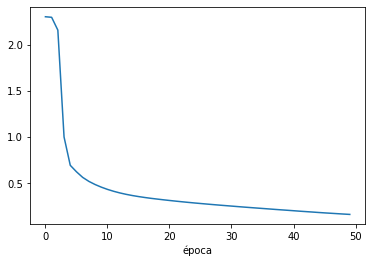

In [18]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [19]:
loss_epoch_end

[2.303267478942871,
 2.227701187133789,
 1.0923893451690674,
 0.5867354869842529,
 0.5144088864326477,
 0.4502663314342499,
 0.4075140655040741,
 0.37713873386383057,
 0.3534485995769501,
 0.3341451585292816,
 0.3181140422821045,
 0.30457887053489685,
 0.2928348779678345,
 0.2827608287334442,
 0.2738332748413086,
 0.26577427983283997,
 0.2583288252353668,
 0.25117501616477966,
 0.24439716339111328,
 0.2378995716571808,
 0.23167717456817627,
 0.22562651336193085,
 0.21984528005123138,
 0.21429124474525452,
 0.20894214510917664,
 0.2038729339838028,
 0.19903428852558136,
 0.19439975917339325,
 0.18994098901748657,
 0.18564006686210632,
 0.18147487938404083,
 0.1774490773677826,
 0.1734725534915924,
 0.1694747507572174,
 0.16547326743602753,
 0.1615050882101059,
 0.15746401250362396,
 0.15340447425842285,
 0.14926907420158386,
 0.14520640671253204,
 0.1412365883588791,
 0.13712678849697113,
 0.1331038475036621,
 0.12914668023586273,
 0.12515045702457428,
 0.1211676225066185,
 0.1173172593

In [20]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    2.303267478942871,
    2.227701187133789,
    1.0923893451690674,
    0.5867354869842529,
    0.5144089460372925,
    0.45026642084121704,
    0.4075140357017517,
    0.37713879346847534,
    0.3534485101699829,
    0.3341451585292816,
    0.3181140422821045,
    0.30457887053489685,
    0.29283496737480164,
    0.2827608287334442,
    0.2738332152366638,
    0.2657742500305176,
    0.2583288848400116,
    0.25117507576942444,
    0.24439716339111328,
    0.23789969086647034,
    0.23167723417282104,
    0.22562651336193085,
    0.21984536945819855,
    0.2142913043498993,
    0.20894232392311096,
    0.203872948884964,
    0.19903430342674255,
    0.19439971446990967,
    0.18994088470935822,
    0.18563991785049438,
    0.18147490918636322,
    0.17744913697242737,
    0.17347246408462524,
    0.16947467625141144,
    0.16547319293022156,
    0.16150487959384918,
    0.1574639081954956,
    0.1534043848514557,
    0.14926929771900177,
    0.1452063024044037,
    0.1412365883588791,
    0.13712672889232635,
    0.1331038922071457,
    0.1291467249393463,
    0.1251506358385086,
    0.12116757035255432,
    0.11731722950935364,
    0.11364627629518509,
    0.11001908034086227,
    0.10655981302261353])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

In [21]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 229 operations to synchronize with Neptune. Do not kill this process.


All 229 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/leolellisr/dl-ia025/e/DLIA-28
